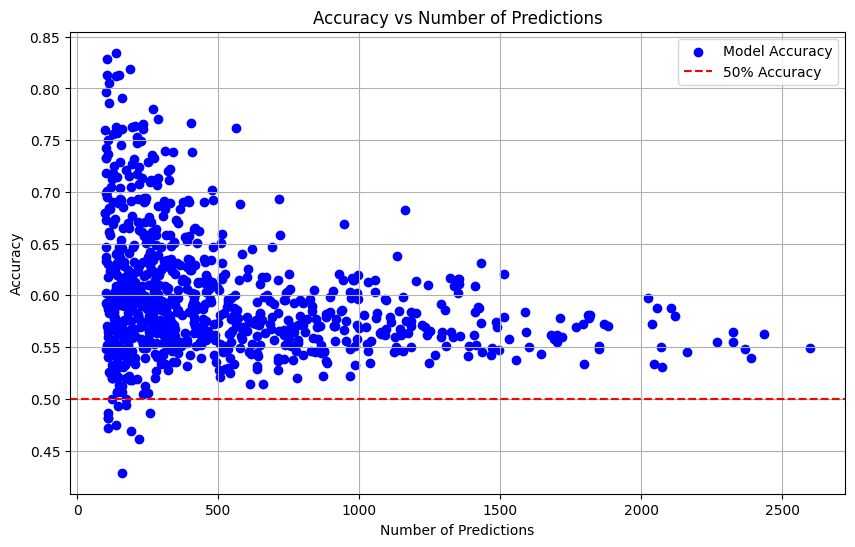

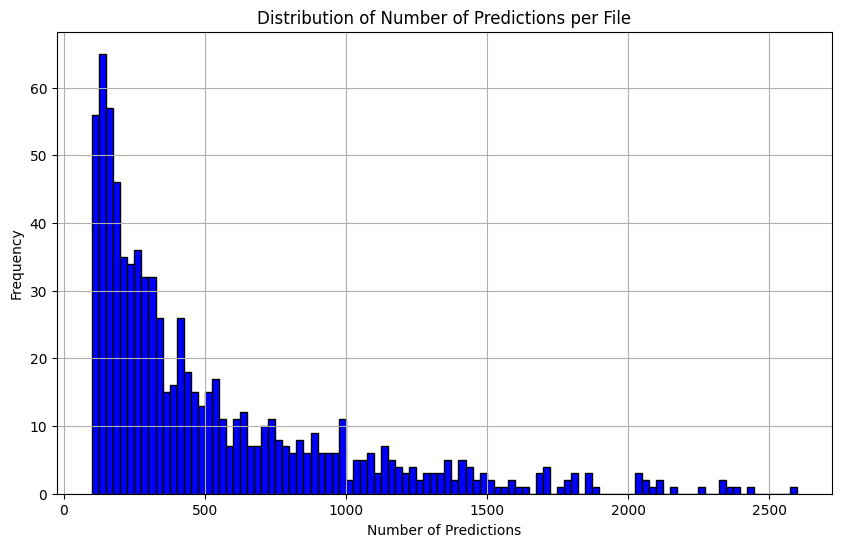

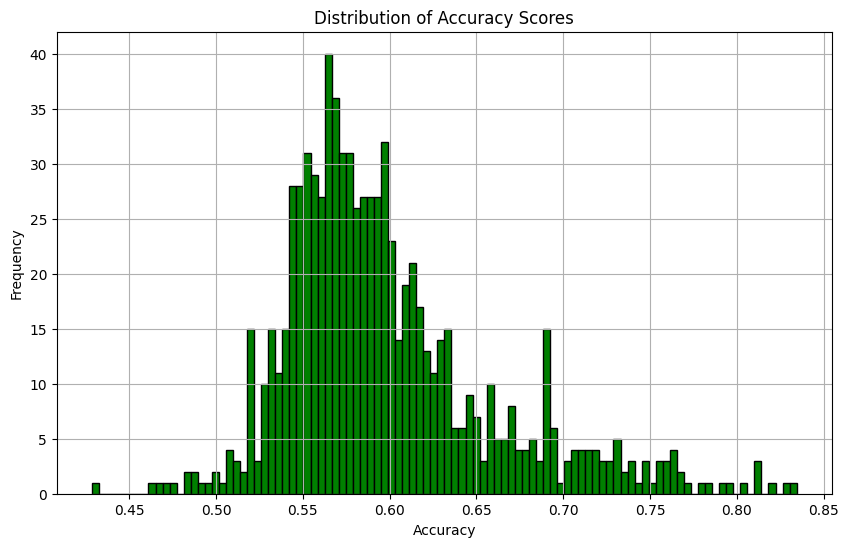

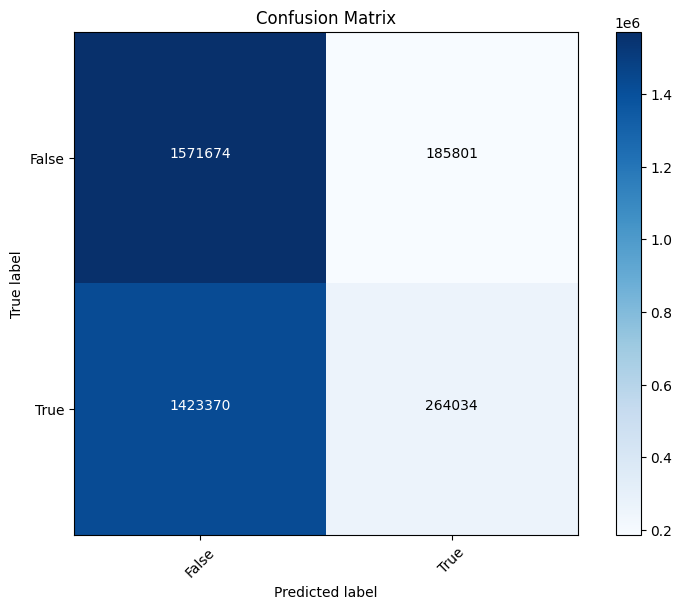

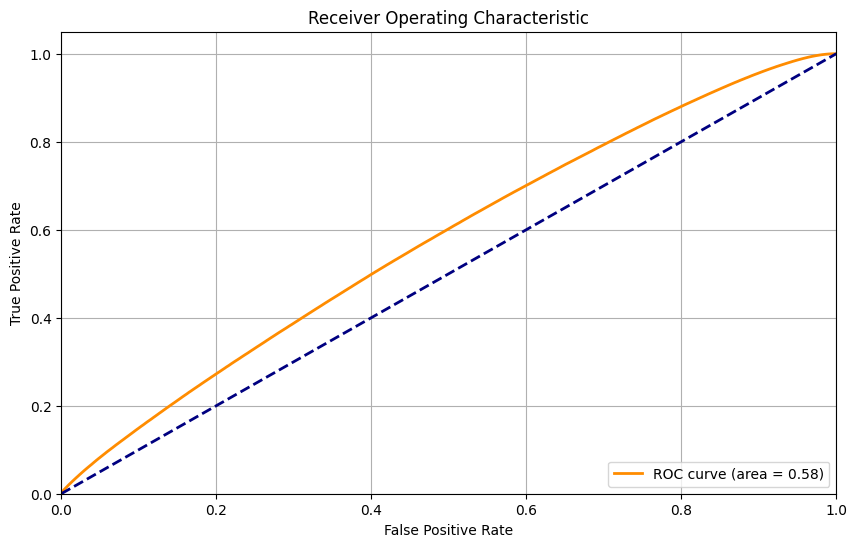

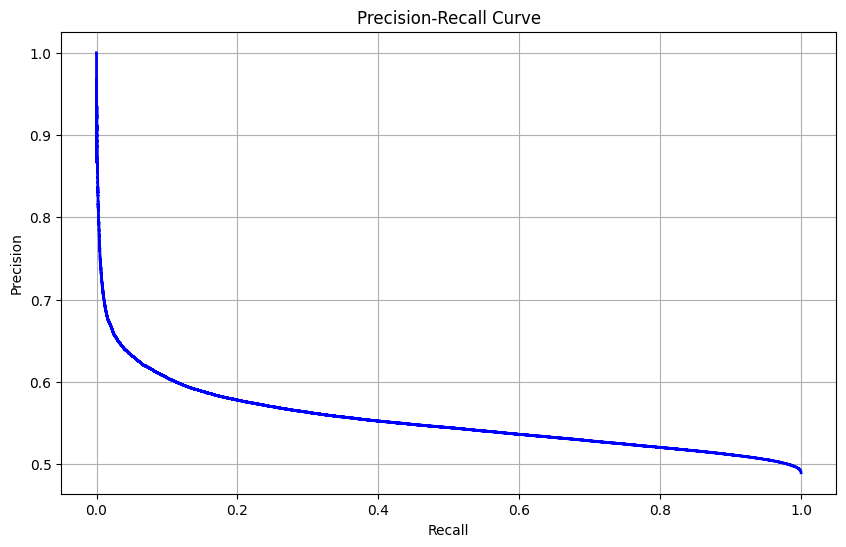


Validation Summary:
Total files processed: 1449
Total files with >= 100 predictions: 820
Average Accuracy: 0.60
Files with insufficient predictions:
  - REAL.parquet
  - SKIN.parquet
  - OVLY.parquet
  - PEPG.parquet
  - CPSS.parquet
  - REYN.parquet
  - ITI.parquet
  - LILA.parquet
  - ELYM.parquet
  - FROG.parquet
  - GCMG.parquet
  - IRON.parquet
  - SLM.parquet
  - PDLB.parquet
  - CERT.parquet
  - PTVE.parquet
  - TRDA.parquet
  - EVLV.parquet
  - NCNO.parquet
  - INNV.parquet
  - TSLA.parquet
  - LEGH.parquet
  - RNA.parquet
  - GEHC.parquet
  - AUR.parquet
  - BMEA.parquet
  - RICK.parquet
  - CRCT.parquet
  - TGTX.parquet
  - TMCI.parquet
  - AAOI.parquet
  - CGEM.parquet
  - ATEC.parquet
  - UPWK.parquet
  - THRY.parquet
  - BSVN.parquet
  - SVII.parquet
  - DKNG.parquet
  - BFST.parquet
  - WSBF.parquet
  - BRZE.parquet
  - ZI.parquet
  - TERN.parquet
  - AGEN.parquet
  - IGMS.parquet
  - NPCE.parquet
  - CLBK.parquet
  - VALU.parquet
  - CMPX.parquet
  - GLUE.parquet
  - LW

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

def validate_model_with_min_predictions(directory_path, min_predictions=100):
    summary_results = {
        "total_files": 0,
        "total_files_with_min_predictions": 0,
        "model_accuracies": [],
        "combined_accuracy": [],
        "files_with_few_predictions": [],
        "prediction_counts": [],
        "true_labels": [],
        "predicted_probs": [],
        "predicted_labels": []
    }

    files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)
        data = pd.read_parquet(file_path)

        ##ensure there are at least 90 days of data if it does not have 90 days of data skip
        if len(data) < 90:
            continue

        data['Date'] = pd.to_datetime(data['Date'])
        data['percentMove'] = data['Close'].pct_change()
        data['next_day_price_rise'] = data['percentMove'].shift(-1) > 0

        summary_results["total_files"] += 1

        prediction_col = 'UpPrediction'
        probability_col = 'UpProbability'

        selected_data = data[data[prediction_col] == 1].copy()
        TP = selected_data[selected_data['next_day_price_rise']].shape[0]
        total_predictions = selected_data.shape[0]

        if total_predictions >= min_predictions:
            accuracy = TP / total_predictions if total_predictions else 0
            summary_results['model_accuracies'].append(accuracy)
            summary_results['prediction_counts'].append(total_predictions)
            summary_results["total_files_with_min_predictions"] += 1
        else:
            summary_results['files_with_few_predictions'].append(file_name)

        summary_results['true_labels'].extend(data['next_day_price_rise'])
        summary_results['predicted_probs'].extend(data[probability_col])
        summary_results['predicted_labels'].extend(data[prediction_col])

    return summary_results

def plot_accuracy_vs_predictions(summary):
    plt.figure(figsize=(10, 6))
    x_values = summary['prediction_counts']
    y_values = summary['model_accuracies']
    
    if x_values and y_values:
        plt.scatter(x_values, y_values, color='blue', label="Model Accuracy")
    
    plt.title('Accuracy vs Number of Predictions')
    plt.axhline(y=0.5, color='r', linestyle='--', label='50% Accuracy')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_distribution_of_predictions(summary):
    plt.figure(figsize=(10, 6))
    plt.hist(summary['prediction_counts'], bins=100, color='blue', edgecolor='black')
    plt.title('Distribution of Number of Predictions per File')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(summary['model_accuracies'], bins=100, color='green', edgecolor='black')
    plt.title('Distribution of Accuracy Scores')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(summary):
    y_true = summary['true_labels']
    y_pred = summary['predicted_labels']
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', lw=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

def print_summary(summary):
    print("\nValidation Summary:")
    print(f"Total files processed: {summary['total_files']}")
    print(f"Total files with >= {min_predictions} predictions: {summary['total_files_with_min_predictions']}")
    
    if summary['model_accuracies']:
        print(f"Average Accuracy: {np.mean(summary['model_accuracies']):.2f}")
    print("Files with insufficient predictions:")
    for file in summary['files_with_few_predictions']:
        print(f"  - {file}")

# Example usage
directory_path = 'Data/RFpredictions'
min_predictions = 100
summary_results = validate_model_with_min_predictions(directory_path, min_predictions)
plot_accuracy_vs_predictions(summary_results)
plot_distribution_of_predictions(summary_results)
plot_confusion_matrix(summary_results)
plot_roc_curve(summary_results)
plot_precision_recall_curve(summary_results)
print_summary(summary_results)

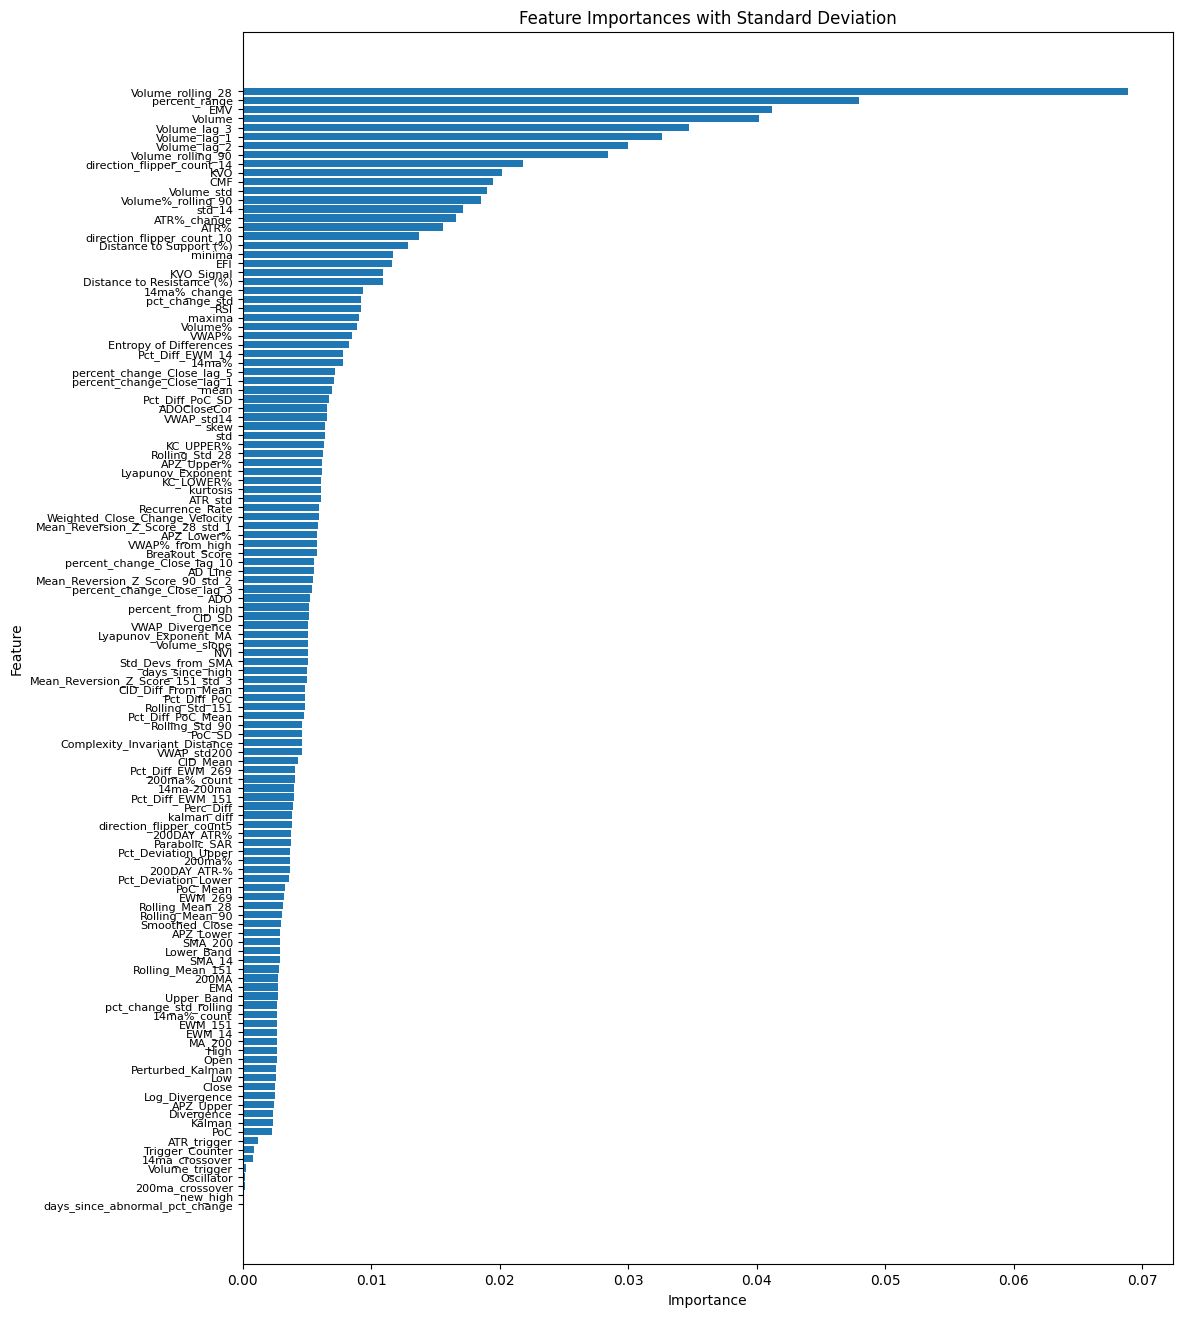

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature importance data
file_path = 'Data/ModelData/FeatureImportances/feature_importance.parquet'
feature_importance_df = pd.read_parquet(file_path)
##after loading the data sort it by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(12, 16))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')




plt.ylabel('Feature')

##space the labels out a bit more 
plt.yticks(fontsize=8)

plt.title('Feature Importances with Standard Deviation')
plt.gca().invert_yaxis()
plt.show()
